<a href="https://colab.research.google.com/github/Rakhayeva/Data-Science-Projects-in-English/blob/main/linear_models_in_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Description

The project aims to develop a machine learning model for the "Volny Lug" dairy farm to optimize the process of selecting cows for herd expansion. The farmer wants to ensure a stable level of milk production (at least 6000 kg per year) and satisfy their own quality criteria regarding the taste of the milk. To achieve this goal, two models will be developed: the first will predict the cow's milk yield, and the second — the probability that the milk will meet the taste requirements. The data for analysis will be provided by the "EcoFarm" pasture association, which will allow for the creation of reliable and grounded forecasts.


**Project Objectives**

- **Milk Yield Prediction**: Creation of a model capable of estimating a cow's potential milk yield based on available characteristics (age, breed, feed composition, etc.).
- **Milk Taste Assessment**: Development of a model that determines the probability of milk being tasty, taking into account the farmer's personalized criteria.
- **Purchase Process Optimization**: Providing the farmer with tools to make more informed decisions when choosing cows for purchase, minimizing risks and increasing dairy farm productivity.


**Research Flow**

Step 1: [Data loading and exploration](#exploration)

Step 2: [Data preprocessing](#preprocessing)

Step 3: [Exploratory Data Analysis (EDA)](EDA)

Step 4: [Correlation analysis](#analysis)

Step 5: [Regression task](#regression)

Step 6: [Classification task](#classification)


**Data Description**

*Column names and their content are in Russian. However, they will be translated into English and renamed after reading files.*

The file `ferma_main.csv` contains data about the farmer's current herd:
- `id` — unique identifier of the cow.
- `Удой, кг` — mass of milk the cow produces per year (in kilograms).
- `ЭКЕ (Энергетическая кормовая единица)` — Feed Energy Unit (FEU), a measure of the cow's feed nutritional value.
- `Сырой протеин, г` — crude protein content in the feed (in grams).
СПО (Сахаро-протеиновое соотношение) — Sugar-Protein Ratio (SPR) in the cow's feed.
- `Порода` — cow's breed.
- `Тип пастбища` — landscape of the meadows where the cow grazed.
порода папы_быка — breed of the cow's sire (father).
- `Жирность,%` — fat content in milk (percentage).
- `Белок,%` — protein content in milk (percentage).
- `кус молока` — taste evaluation based on the farmer's personal criteria, binary feature (tasty, not tasty).
- `Возраст` — cow's age, binary feature (less_than_2_years, more_than_2_years).

The file `ferma_dad.csv` stores the name of the sire for each cow in the farmer's herd:
- `id` — unique identifier of the cow.
- `Имя Папы` — name of the cow's sire.

The file `cow_buy.csv` contains data about "EcoFarm" cows that the farmer wants to study before purchasing:
- `Порода` — cow's breed.
- `Тип пастбища` — landscape of the meadows where the cow grazed.
порода папы_быка — breed of the cow's sire.
- `Имя_папы` — name of the cow's sire.
- `Текущая_жирность,%` — current fat content in milk (percentage).
- `Текущий_уровень_белок,%`- — current protein content in milk (percentage).
- `Возраст` — cow's age, binary feature (less_than_2_years, more_than_2_years).



### Importing libraries and modules

In [1]:
# Imporingt modules
!pip install phik -q

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from scipy import stats as st

# Sklearn imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,
                             accuracy_score, precision_score, recall_score,
                             confusion_matrix, precision_recall_curve)

# Settings
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Constant for reproducibility
RANDOM_STATE = 42

### Functions

In [4]:
# Column Renaming Maps
RENAME_MAPS = {
    'ferma': {
        'Удой, кг': 'milk_yield_kg',
        'ЭКЕ (Энергетическая кормовая единица)': 'energy_feed_unit',
        'Сырой протеин, г': 'crude_protein_g',
        'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio',
        'Порода': 'breed',
        'Тип пастбища': 'pasture_type',
        'порода папы_быка': 'sire_breed',
        'Жирность,%': 'fat_percentage',
        'Белок,%': 'protein_percentage',
        'Вкус молока': 'milk_flavor',
        'Возраст': 'age'
    },
    'dad': {'Имя Папы': 'sire_name'},
    'buy': {
        'Порода': 'breed',
        'Тип пастбища': 'pasture_type',
        'порода папы_быка': 'sire_breed',
        'Имя_папы': 'sire_name',
        'Текущая_жирность,%': 'current_fat_percentage',
        'Текущий_уровень_белок,%': 'current_protein_percentage',
        'Возраст': 'age'
    }
}

# Value Translation Maps
VALUE_MAPS = {
    'breed': {'вис бик айдиал': 'vis bic ideal', 'рефлешн соверин': 'reflection sovereign',
              'айдиал': 'ideal', 'соверин': 'sovereign', 'айдиалл': 'ideal', 'рефлешнсоверинг': 'reflection sovereign'},
    'pasture_type': {'равнинное': 'flat', 'холмистое': 'hilly', 'равнинные': 'flat'},
    'milk_flavor': {'вкусно': 'tasty', 'не вкусно': 'not_tasty'},
    'age': {'менее_2_лет': 'less_than_2_years', 'более_2_лет': 'more_than_2_years'},
    'sire_name': {'буйный': 'buyny', 'соловчик': 'solovchik', 'барин': 'barin', 'геркулес': 'hercules'},
    'sire_breed': {'айдиал': 'ideal', 'айдиалл': 'ideal', 'соверин': 'sovereign'}
}

In [5]:
# Load and clear function
def load_and_process(file_path, map_key):
    # Load
    try:
        df = pd.read_csv(file_path, sep=';', decimal=',')
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return pd.DataFrame()

    # Rename columns
    if map_key in RENAME_MAPS:
        df = df.rename(columns=RENAME_MAPS[map_key])

    # Drop full duplicates
    df = df.drop_duplicates().reset_index(drop=True)

    # Process string columns (lower case + translations)
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.lower().str.split().str.join(' ') # Fix spaces
        if col in VALUE_MAPS:
            df[col] = df[col].replace(VALUE_MAPS[col])

    return df


In [6]:
# dataset analyzing function
def analyze_dataframe(df):
    # ANSI code for bold text
    bold_start = '\033[1m'
    bold_end = '\033[0m'

    # Output general information about the data
    print(f"\n{bold_start}General information about DataFrame:{bold_end}\n")
    df.info()

    # Output the first 5 rows
    print(f"{bold_start}First 5 rows:{bold_end}")
    display(df.head())

    # Number of duplicates
    duplicates = df.duplicated().sum()
    print(f"\n{bold_start}Number of duplicates:{bold_end} {duplicates}")

    # Check for missing values
    print(f"\n{bold_start}Missing values in each column:{bold_end}")
    display(df.isnull().sum())

In [7]:
# The function plots graphs for any set of columns
def plot_eda(df, numeric_cols):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols, 1):
        # Histogram
        plt.subplot(2, 3, i)
        sns.histplot(df[col], bins=20, kde=True, color='skyblue')
        plt.title(f'Distribution: {col}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols, 1):
        # Boxplot
        plt.subplot(2, 3, i)
        sns.boxplot(y=df[col], color='lightblue')
        plt.title(f'Boxplot: {col}')
    plt.tight_layout()
    plt.show()

In [8]:
# Function for categorical distributions
def plot_pie_charts(df, cols, rows=1, cols_num=1, figsize=(15, 10), title=None):
    if isinstance(cols, str):
        cols = [cols]

    plt.figure(figsize=figsize)

    if title:
        plt.suptitle(title, fontsize=16, y=1.02)

    for i, col in enumerate(cols, 1):
        if i > rows * cols_num:
            break
        plt.subplot(rows, cols_num, i)
        # Check if column exists to avoid errors
        if col in df.columns:
            df[col].value_counts().plot.pie(
                autopct='%1.1f%%',
                startangle=45,
                colors=plt.cm.tab20.colors
            )
            plt.title(f'{col}')
            plt.ylabel('')
            plt.axis('equal')
        else:
            print(f"Warning: Column '{col}' not found.")

    plt.tight_layout()
    plt.show()

In [9]:
def preprocess_and_split(df, target_col, cat_cols, num_cols):
    """
    Performs OHE, Scaling, and Train/Test Split.
    Returns X_train, X_valid, y_train, y_valid, and the fitted objects (encoder/scaler).
    """
    # Split X and y
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Split into Train and Valid
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, random_state=RANDOM_STATE
    )

    # 1. Encode Categorical
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    X_train_ohe = pd.DataFrame(
        encoder.fit_transform(X_train[cat_cols]),
        columns=encoder.get_feature_names_out(cat_cols),
        index=X_train.index
    )
    X_valid_ohe = pd.DataFrame(
        encoder.transform(X_valid[cat_cols]),
        columns=encoder.get_feature_names_out(cat_cols),
        index=X_valid.index
    )

    # 2. Scale Quantitative
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train[num_cols]),
        columns=num_cols,
        index=X_train.index
    )
    X_valid_scaled = pd.DataFrame(
        scaler.transform(X_valid[num_cols]),
        columns=num_cols,
        index=X_valid.index
    )

    # 3. Concatenate
    X_train_final = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_valid_final = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)

    return X_train_final, X_valid_final, y_train, y_valid, encoder, scaler

In [10]:
def evaluate_regression(model, X_valid, y_valid, name="Model"):
    """Predicts, prints metrics, and plots residuals."""
    predictions = model.predict(X_valid)

    # Calculate Metricas
    r2 = r2_score(y_valid, predictions)
    mse = mean_squared_error(y_valid, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, predictions)

    print(f"--- {name} Results ---")
    print(f'R²: {r2:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}')

    # Plot Residuals
    residuals = y_valid - predictions
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Histogram
    axes[0].hist(residuals, bins=30, color='lightgreen', edgecolor='black')
    axes[0].set_title('Residuals Distribution')
    axes[0].set_xlabel('Residuals')

    # Scatter
    axes[1].scatter(predictions, residuals, color='green', alpha=0.4)
    axes[1].axhline(0, color='red', linestyle='--')
    axes[1].set_title('Residuals vs Predictions')
    axes[1].set_xlabel('Predictions')
    axes[1].set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()

    return predictions, residuals, metrics_dict(r2, mse, rmse, mae)

In [11]:
def metrics_dict(r2, mse, rmse, mae):
    return {'r2': r2, 'mse': mse, 'rmse': rmse, 'mae': mae}

In [12]:
def threshold_analysis(thresholds, proba, y_true):
    results = []
    for th in thresholds:
        preds = (proba > th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
        results.append({
            'Threshold': th,
            'Precision': precision_score(y_true, preds, zero_division=0),
            'Recall': recall_score(y_true, preds, zero_division=0),
            'False Positives': fp
        })
    return pd.DataFrame(results)

### Loading the data

In [13]:
# Loading the data
df_ferma = load_and_process('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/ferma_main.csv', 'ferma')
df_dad = load_and_process('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/ferma_dad.csv', 'dad')
df_buy = load_and_process('/content/drive/MyDrive/Yandex_Practicum/datasets for DS/cow_buy.csv', 'buy')

print("Data loaded and translated successfully.")
display(df_ferma.head(3))

Data loaded and translated successfully.


,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,fat_percentage,protein_percentage,milk_flavor,age
0,1,5863,14.2,1743,0.890,vis bic ideal,flat,ideal,3.58,3.076,tasty,more_than_2_years
1,2,5529,12.8,2138,0.890,vis bic ideal,flat,sovereign,3.54,3.079,tasty,less_than_2_years
2,3,5810,14.0,1854,0.885,reflection sovereign,hilly,sovereign,3.59,3.074,not_tasty,more_than_2_years


In [14]:
analyze_dataframe(df_ferma)


General information about DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   629 non-null    int64  
 1   milk_yield_kg        629 non-null    int64  
 2   energy_feed_unit     629 non-null    float64
 3   crude_protein_g      629 non-null    int64  
 4   sugar_protein_ratio  629 non-null    float64
 5   breed                629 non-null    object 
 6   pasture_type         629 non-null    object 
 7   sire_breed           629 non-null    object 
 8   fat_percentage       629 non-null    float64
 9   protein_percentage   629 non-null    float64
 10  milk_flavor          629 non-null    object 
 11  age                  629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.1+ KB
First 5 rows:


,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,fat_percentage,protein_percentage,milk_flavor,age
0,1,5863,14.2,1743,0.890,vis bic ideal,flat,ideal,3.58,3.076,tasty,more_than_2_years
1,2,5529,12.8,2138,0.890,vis bic ideal,flat,sovereign,3.54,3.079,tasty,less_than_2_years
2,3,5810,14.0,1854,0.885,reflection sovereign,hilly,sovereign,3.59,3.074,not_tasty,more_than_2_years
3,4,5895,12.4,2012,0.885,reflection sovereign,hilly,ideal,3.40,3.075,not_tasty,more_than_2_years
4,5,5302,12.8,1675,0.885,vis bic ideal,flat,sovereign,3.73,3.073,tasty,less_than_2_years



Number of duplicates: 0

Missing values in each column:


,0
id,0
milk_yield_kg,0
energy_feed_unit,0
crude_protein_g,0
sugar_protein_ratio,0
breed,0
pasture_type,0
sire_breed,0
fat_percentage,0
protein_percentage,0


Everything seems ok.

In [15]:
analyze_dataframe(df_dad)


General information about DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         629 non-null    int64 
 1   sire_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB
First 5 rows:


,id,sire_name
0,1,buyny
1,2,solovchik
2,3,barin
3,4,buyny
4,5,barin



Number of duplicates: 0

Missing values in each column:


,0
id,0
sire_name,0


Everything seems ok.

In [16]:
analyze_dataframe(df_buy)


General information about DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   breed                       16 non-null     object 
 1   pasture_type                16 non-null     object 
 2   sire_breed                  16 non-null     object 
 3   sire_name                   16 non-null     object 
 4   current_fat_percentage      16 non-null     float64
 5   current_protein_percentage  16 non-null     float64
 6   age                         16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB
First 5 rows:


,breed,pasture_type,sire_breed,sire_name,current_fat_percentage,current_protein_percentage,age
0,vis bic ideal,hilly,ideal,hercules,3.58,3.076,more_than_2_years
1,vis bic ideal,flat,sovereign,buyny,3.54,3.081,less_than_2_years
2,reflection sovereign,flat,sovereign,barin,3.59,3.074,more_than_2_years
3,reflection sovereign,hilly,ideal,buyny,3.40,3.061,more_than_2_years
4,reflection sovereign,flat,ideal,buyny,3.64,3.074,more_than_2_years



Number of duplicates: 0

Missing values in each column:


,0
breed,0
pasture_type,0
sire_breed,0
sire_name,0
current_fat_percentage,0
current_protein_percentage,0
age,0


Everything seems ok. But regardless absence of duolicates we will check for implicit ones.

## <a name='preprocessing'></a>  Data Preprocessing

### Data Type Conversion & Duplicate Removal

In [17]:
# Dictionary with column names to check for implicit duplicates in each DataFrame
columns_to_check = {
    'df_ferma': ['breed', 'pasture_type', 'sire_breed'],
    'df_dad': ['sire_name'],
    'df_buy': ['breed', 'pasture_type', 'sire_breed', 'sire_name']
}

# Checking for implicit duplicates
for df_name, columns in columns_to_check.items():
    df = eval(df_name)  # Get DataFrame by name
    for column in columns:
        # Find unique values and their counts
        unique_values = df[column].unique()
        print(unique_values)

['vis bic ideal' 'reflection sovereign']
['flat' 'hilly']
['ideal' 'sovereign']
['buyny' 'solovchik' 'barin' 'hercules']
['vis bic ideal' 'reflection sovereign']
['hilly' 'flat']
['ideal' 'sovereign']
['hercules' 'buyny' 'barin' 'solovchik']


Everything seems ok.

## <a name='EDA'></a> Exploratory Data Analysis (EDA)

### df_ferma

In [18]:
df_ferma.describe()

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,fat_percentage,protein_percentage
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


`milk_yield_kg` has a mean of 6188.75 kg, min 5204 kg, and max 45616 kg, indicating the presence of outliers or anomalously high values.

**Necessary:**
- Build a boxplot for milk_yield_kg to look at the nature of the outliers in detail.
- Histograms and boxplots for quantitative features.
- Pie charts for categorical features.

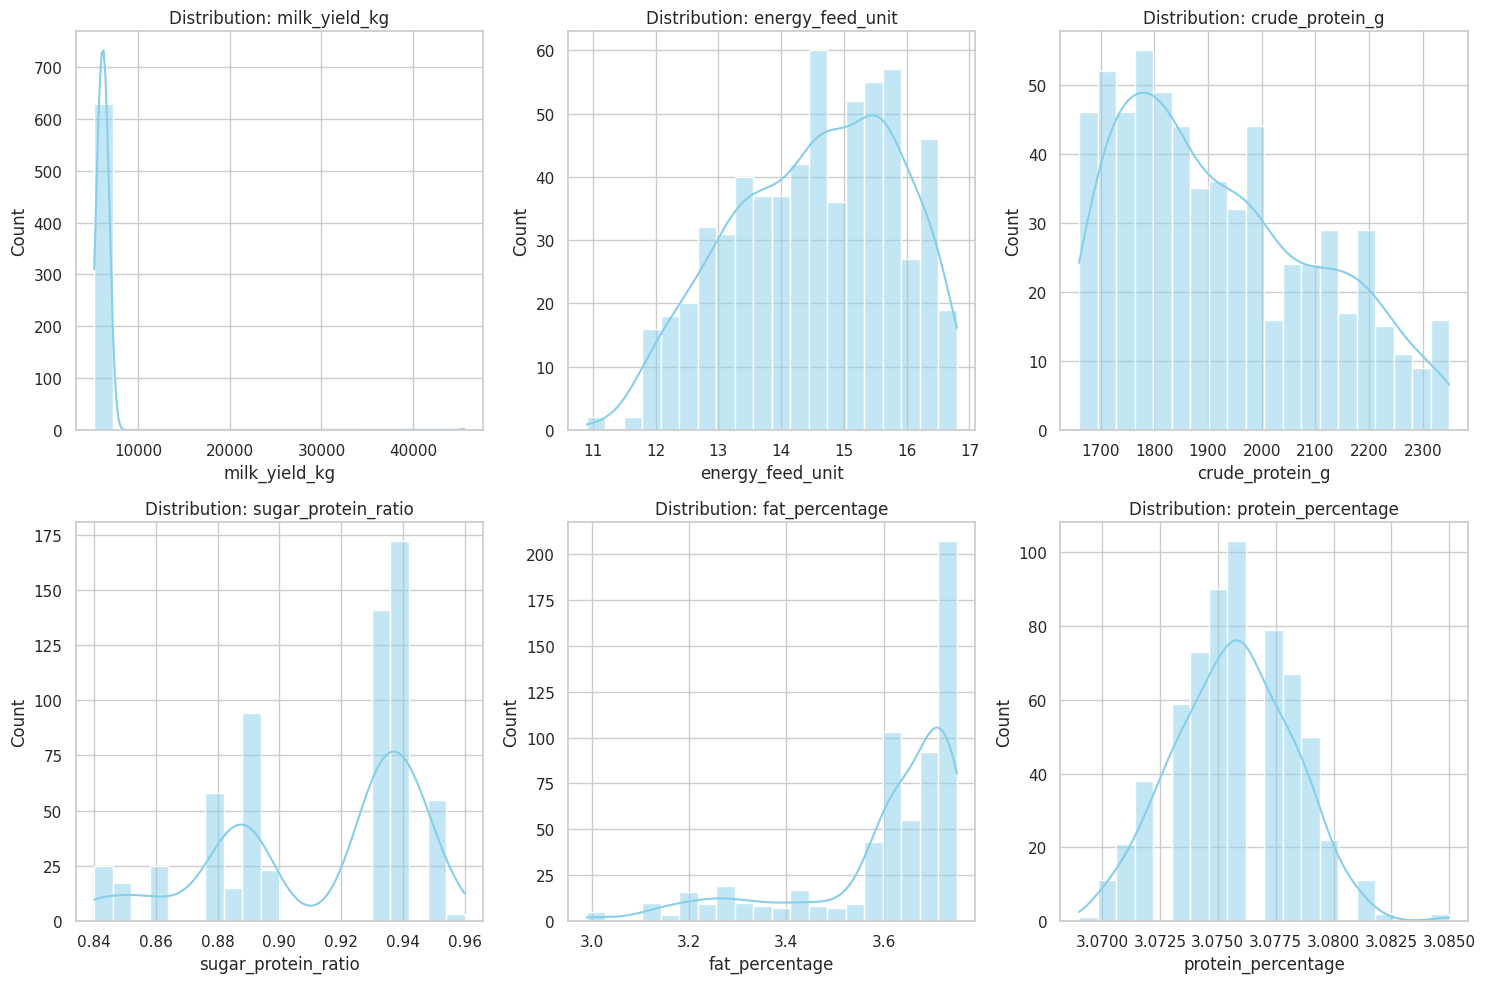

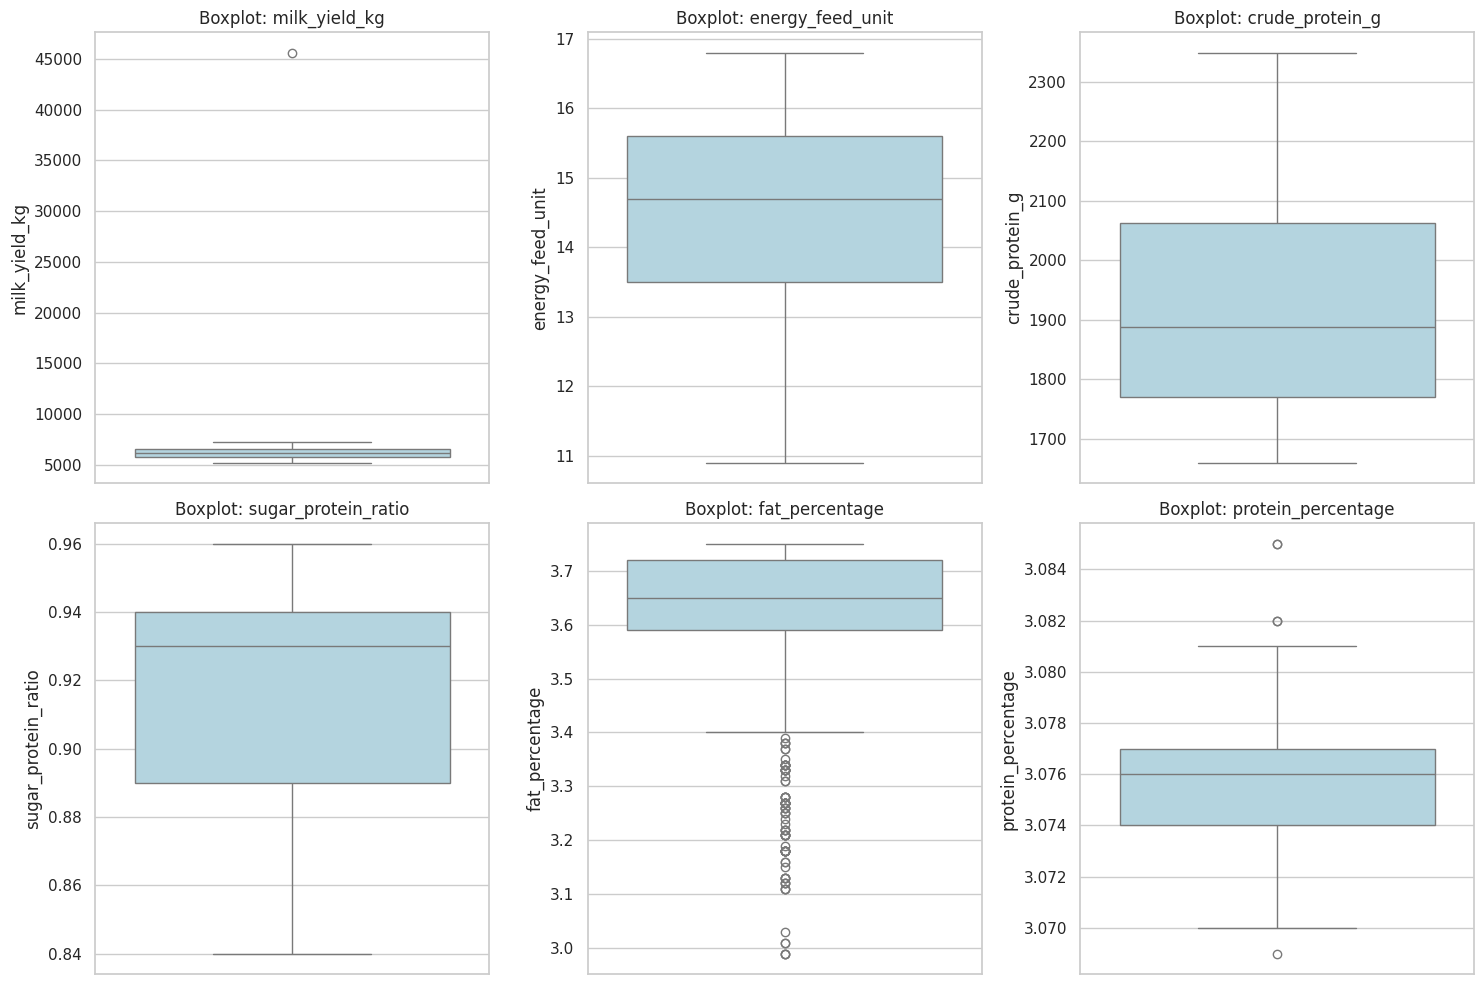

In [19]:
# Plotting
num_cols = ['milk_yield_kg', 'energy_feed_unit', 'crude_protein_g',
            'sugar_protein_ratio', 'fat_percentage', 'protein_percentage']
plot_eda(df_ferma, num_cols)

There is one outlier at 45616. Let's check the record with this value.

In [20]:
df_ferma[df_ferma['milk_yield_kg'] == 45616]

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,fat_percentage,protein_percentage,milk_flavor,age
16,17,45616,11.5,1675,0.93,vis bic ideal,hilly,ideal,3.22,3.076,tasty,more_than_2_years


There was clearly a data entry error; we will remove the single outlier.

In [21]:
# Removing row with outlier
df_ferma = df_ferma[df_ferma['milk_yield_kg'] != 45616]

In [22]:
# let's check
df_ferma['milk_yield_kg'].describe()

,milk_yield_kg
count,628.000000
mean,6125.968153
std,475.857053
min,5204.000000
25%,5749.750000
50%,6132.500000
75%,6501.000000
max,7222.000000


- **Milk Yield (milk_yield_kg)**: Skewed right, most cows give 6000-6500 kg, no outliers (after removal).
- **Energy Feed Unit**: Wide peak between 13 and 16.
- **Crude Protein**: Skewed right.
- **Sugar-Protein Ratio**: Irregular with peaks.
- **Fat Percentage**: Skewed left, most > 3.6%.
- **Protein Percentage**: Normal distribution with slight deviations. Small outliers exist.

Most features are distributed irregularly.

In [23]:
# Checking share of outliers in fat_percentage relative to the whole dataset
print(
    f'Share of rows with outliers in "fat_percentage": {round(len(df_ferma.query("fat_percentage < 3.4")) / len(df_ferma) * 100, 3)}%')

Share of rows with outliers in "fat_percentage": 13.694%


The share of such outliers is substantial (13.694%), so we should not remove them.

In [24]:
# Removing outliers in protein_percentage
df_ferma = df_ferma.query('3.069 < protein_percentage < 3.081 ')

# let's check
df_ferma['protein_percentage'].describe()

,protein_percentage
count,612.000000
mean,3.075534
std,0.002379
min,3.070000
25%,3.074000
50%,3.076000
75%,3.077000
max,3.080000


For categorical data visualization, we use pie charts.

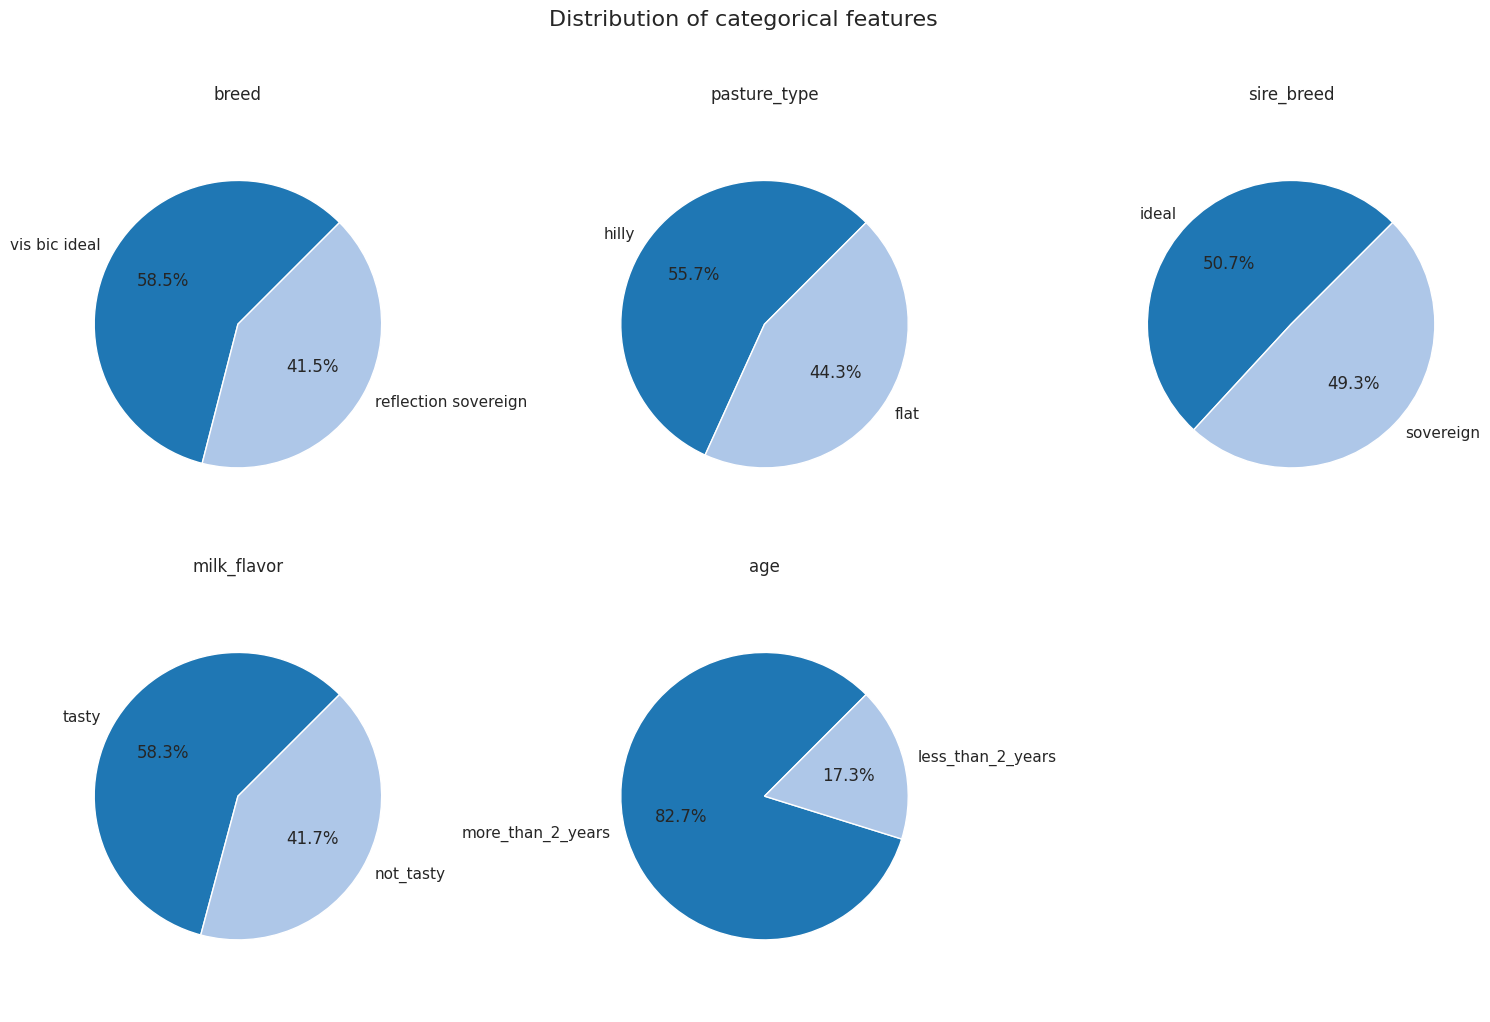

In [25]:
# Defining categorical features
categorical_columns = ['breed', 'pasture_type', 'sire_breed', 'milk_flavor', 'age']

plot_pie_charts(df_ferma, categorical_columns, rows=2, cols_num=3, figsize=(15, 10), title='Distribution of categorical features')

- **Breed: Dominant**: Vis Bic Ideal (58.5%). Minority: Reflection Sovereign (41.5%).
- **Pasture Type**: Hilly (55.7%), Flat (44.3%).
- **Milk Flavor**: Majority 'tasty' (58.3%).
- **Age**: Majority > 2 years (82.7%).

**General Conclusions**: The herd has genetic diversity and a mature age composition. Most cows produce good quality milk.

### df_dad

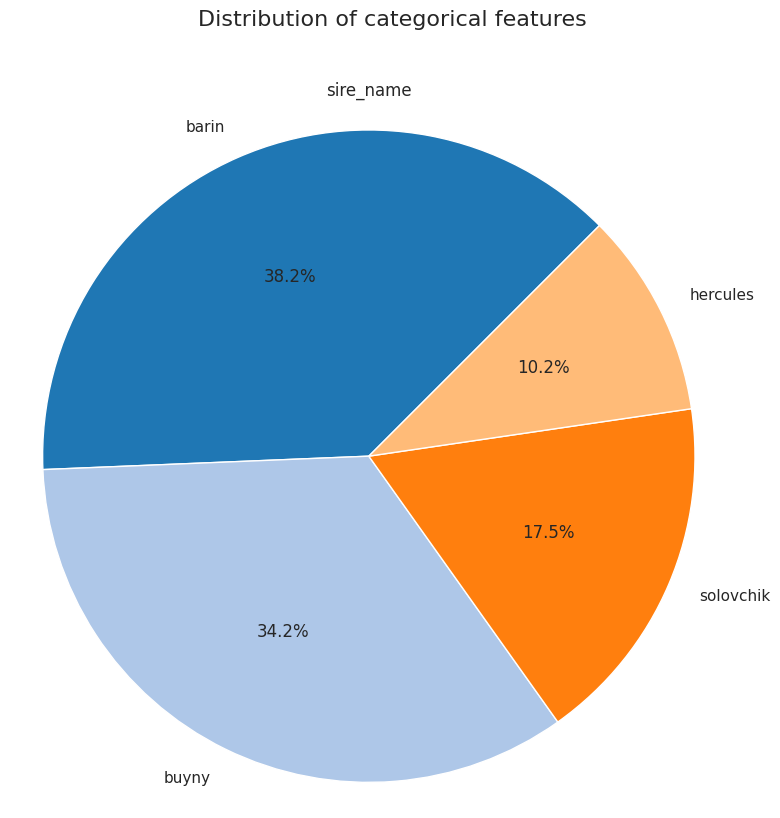

In [26]:
plot_pie_charts(df_dad, 'sire_name', rows=1, cols_num=1, figsize=(8, 8), title='Distribution of categorical features')

`Barin` dominates (38.2%), followed by `Buyny` (34.2%).

### df_buy

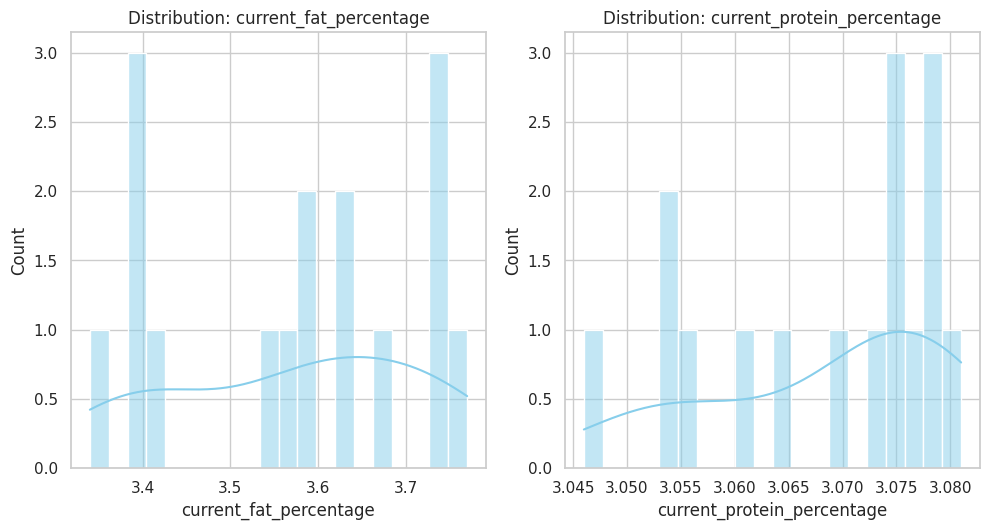

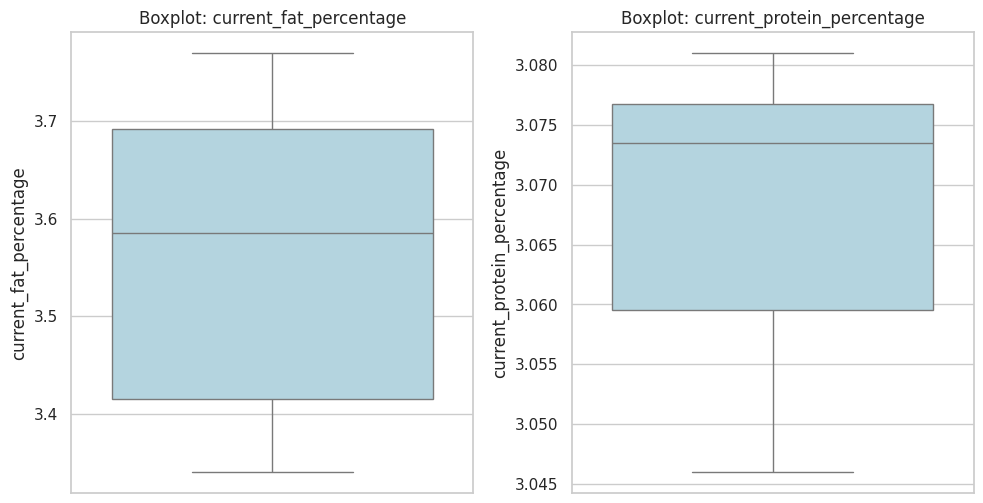

In [27]:
# List of numeric columns
num_cols = ['current_fat_percentage', 'current_protein_percentage']

plot_eda(df_buy, num_cols)

Milk samples from EcoFarm cows are characterized by stable protein content and moderately high fat content, which may indicate a uniform diet. Low variability in protein content indicates consistent feeding.

- **Fat Percentage**: varies 3.3% - 3.8%.
- **Protein Percentage**: varies 3.046% - 3.08%.

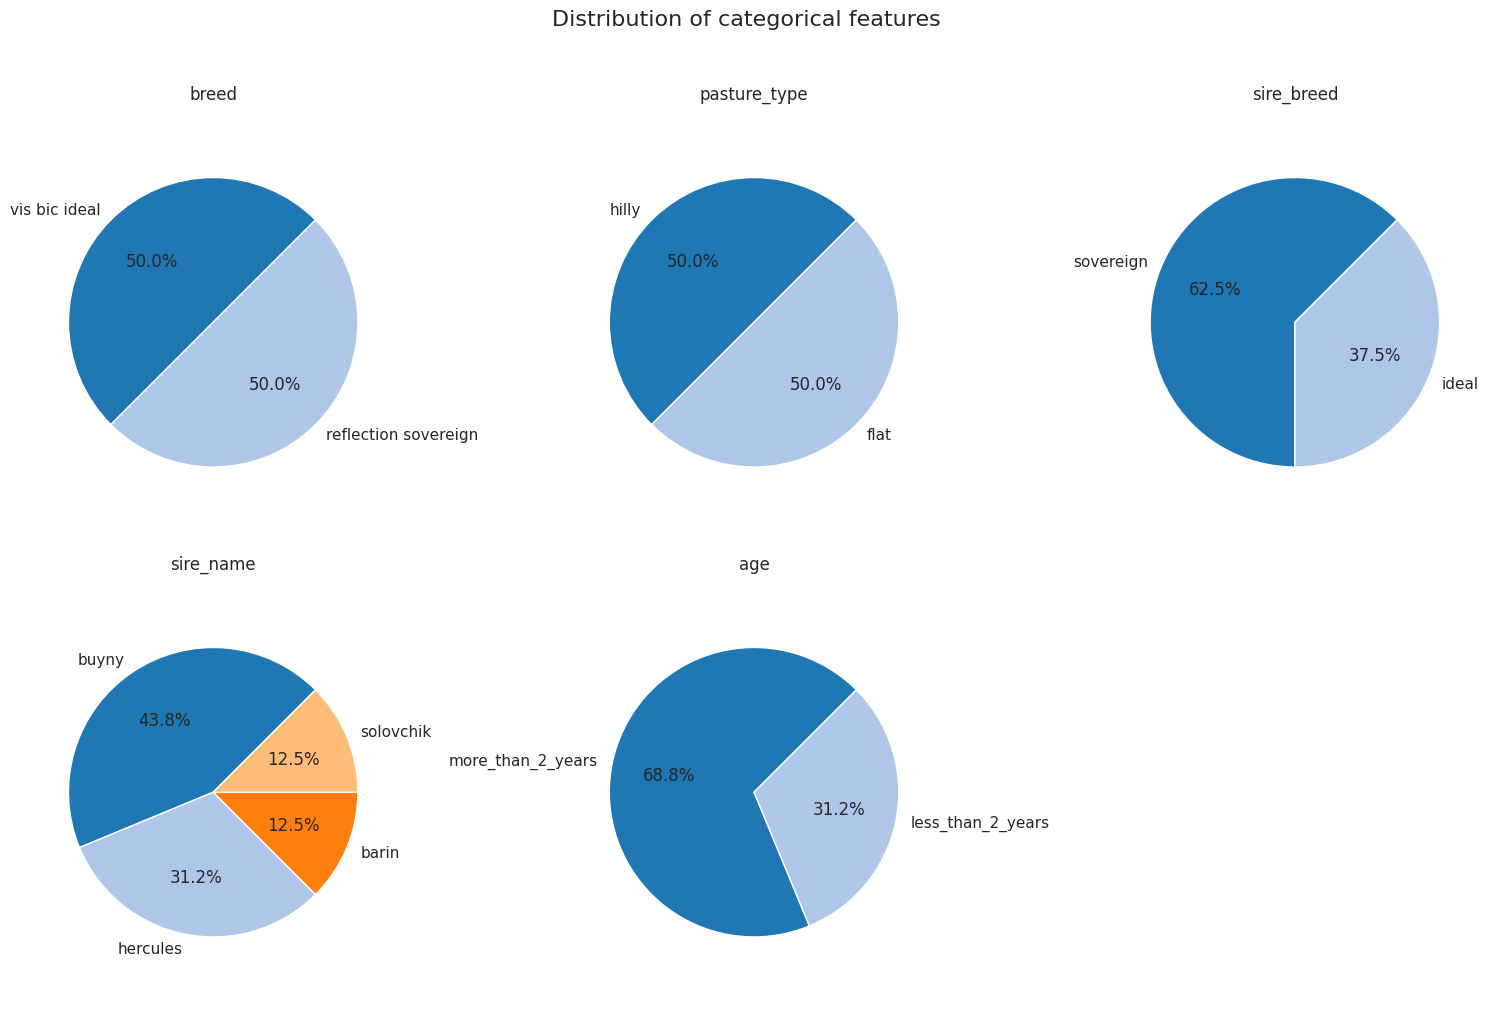

In [28]:
# Defining categorical features
categorical_columns = ['breed', 'pasture_type', 'sire_breed', 'sire_name', 'age']

plot_pie_charts(df_buy, categorical_columns, rows=2, cols_num=3, figsize=(15, 10), title='Distribution of categorical features')

- **Breed**: The herd consists of two breeds of cows, equally distributed: Soverin and Ideal.
- **Pasture**: Cows are equally distributed across two types of pasture: hilly and flat.
- **Breed of Stud Bull**: The herd is dominated by Soverin calves (62.5%) and, to a lesser extent, Ideal calves (37.5%).
- **Stud Name**: The main sires of calves are the bulls Buiny (43.8%) and Hercules (31.2%); calves from Solovchik and Barin bulls make up a smaller portion of the herd (12.5% ​​each).
- **Age**: Most cows are over 2 years old – 68.8%; the rest are younger.

## <a name='analysis'></a> Correlation analysis

Calculating correlation coefficients between all features.

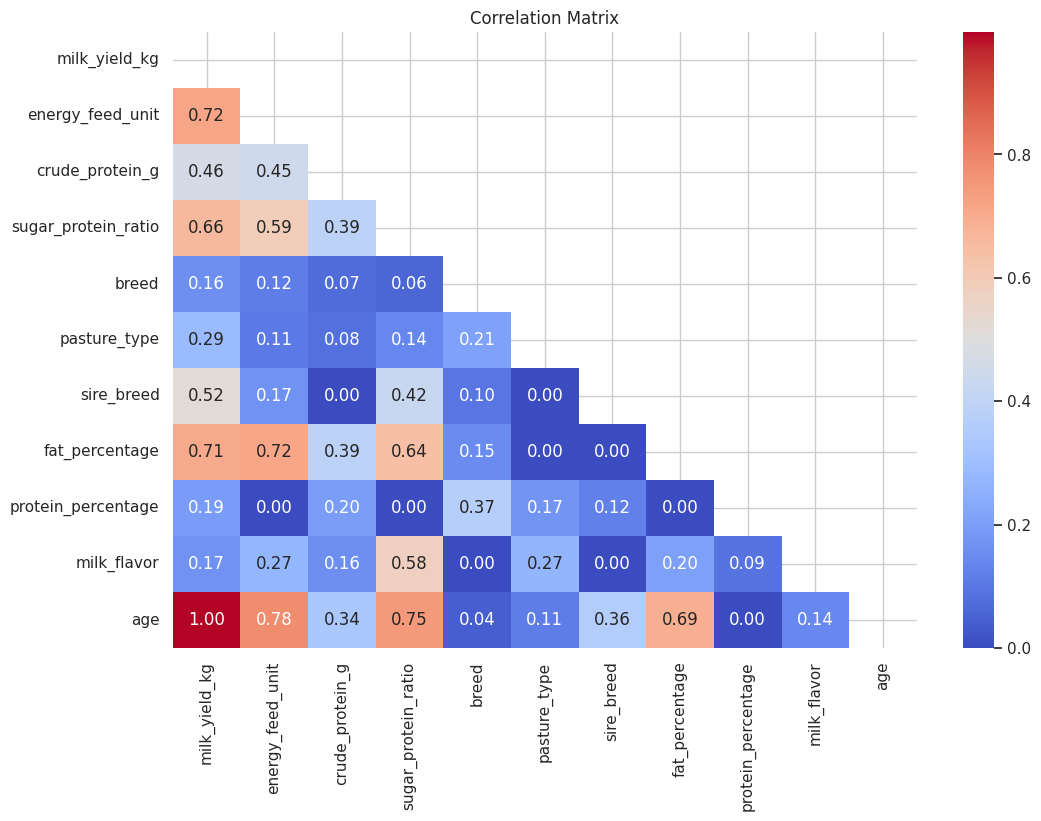

In [29]:
# Correlation analysis
phik_matrix = df_ferma.drop('id', axis=1).phik_matrix(interval_cols=['milk_yield_kg', 'energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'fat_percentage', 'protein_percentage'])

# Visualizing correlation matrix
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Correlation Matrix")
plt.show()

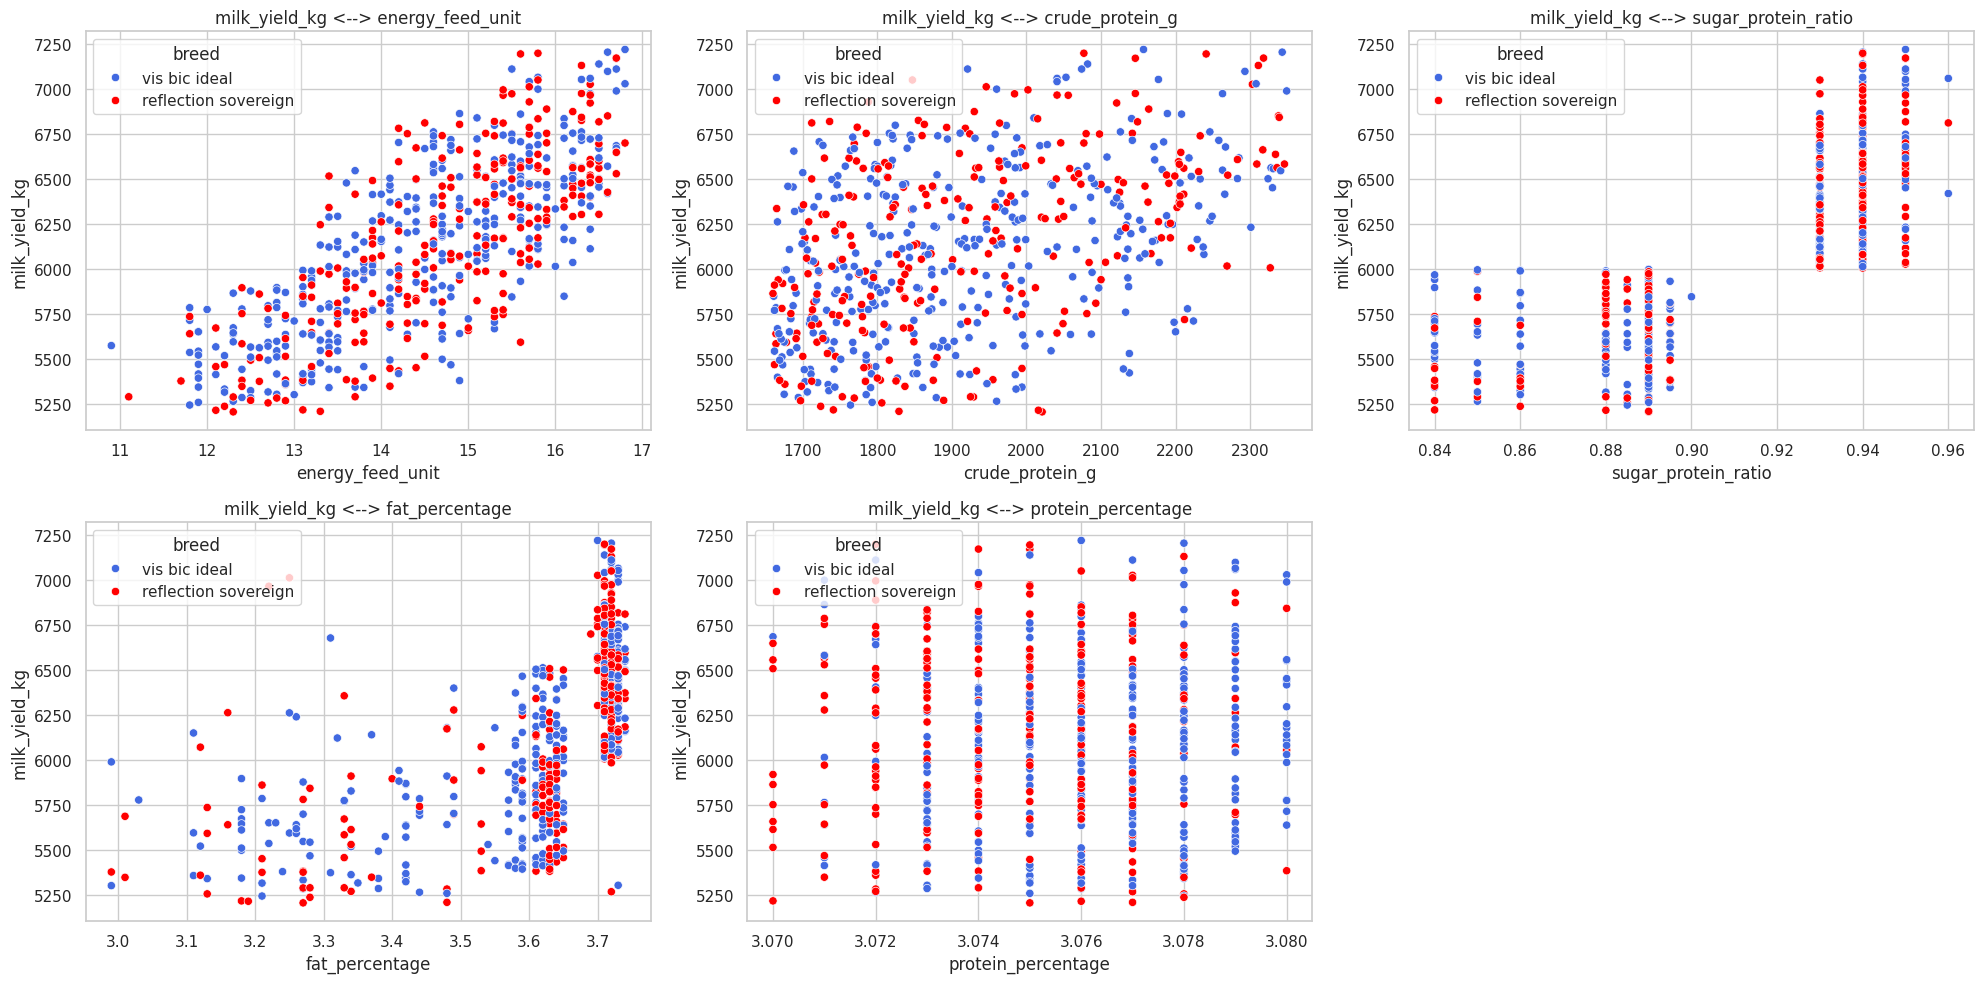

In [30]:
# List of quantitative features
quantitative_columns = ['energy_feed_unit', 'crude_protein_g',
                        'sugar_protein_ratio', 'fat_percentage', 'protein_percentage']

# Scatter plots (hue=breed)
plt.figure(figsize=(20, 10))
for i, feature in enumerate(quantitative_columns, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df_ferma, x=feature, y='milk_yield_kg', hue='breed', palette=['royalblue', 'red'])
    plt.title(f'milk_yield_kg <--> {feature}')

plt.tight_layout()
plt.show()

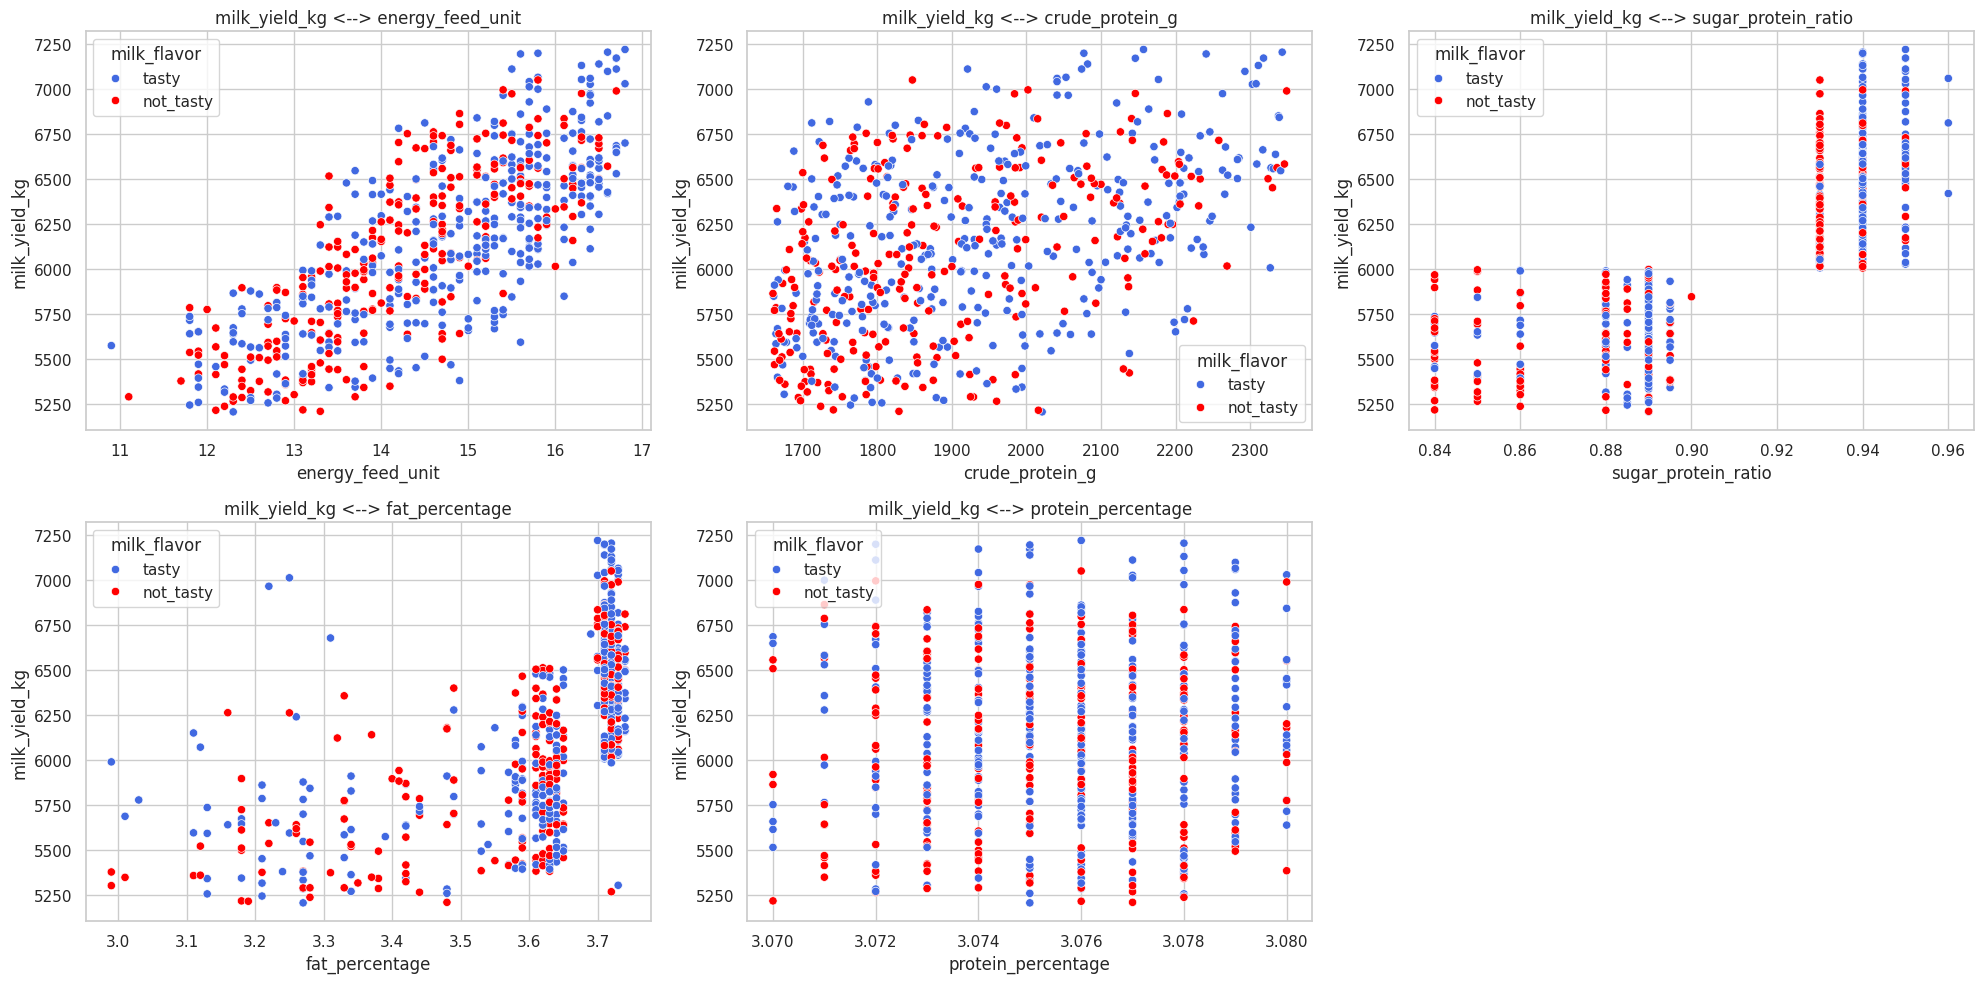

In [31]:
# Scatter plots (hue=milk_flavor)
plt.figure(figsize=(20, 10))
for i, feature in enumerate(quantitative_columns, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df_ferma, x=feature, y='milk_yield_kg', hue='milk_flavor', palette=['royalblue', 'red'])
    plt.title(f'milk_yield_kg <--> {feature}')

plt.tight_layout()
plt.show()

**Conclusions:**
- **Energy Feed Unit**: Strong correlation (0.72) with yield. Non-linear (quadratic) relationship.
- **Sugar-Protein Ratio**: Moderate correlation (0.66). Non-linear, splits into two clusters.
- **Age**: Very high correlation (1.0).
- **Non-linear relationships** detected with all quantitative features.



## <a name='regression'></a> Regression task

### Model №1

We can drop `protein_percentage` (weak link), `id`, and `fat_percentage` (target-related).

--- Model 1 Results ---
R²: 0.8034 | MSE: 48710.0347 | RMSE: 220.7035 | MAE: 169.9506


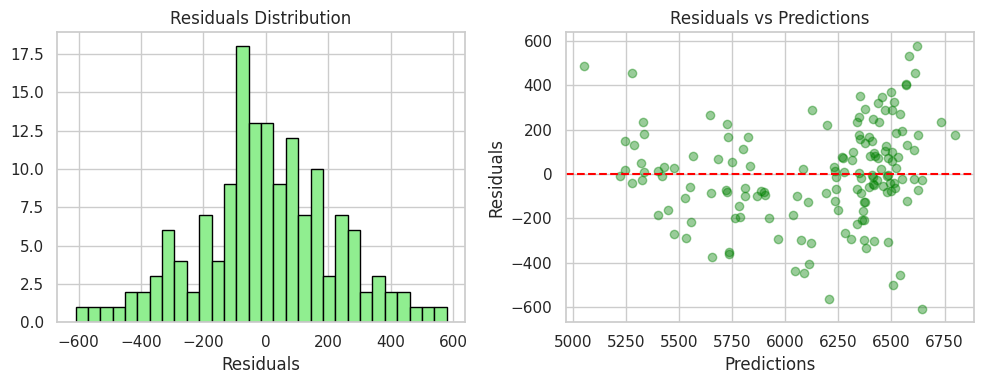

In [32]:
# Drop leakage/irrelevant columns
df_ml_1 = df_ferma.drop(['id', 'protein_percentage', 'fat_percentage'], axis=1)

# Define feature groups
cat_cols = ['breed', 'pasture_type', 'sire_breed', 'milk_flavor', 'age']
num_cols = ['energy_feed_unit', 'sugar_protein_ratio', 'crude_protein_g']

# Preprocess (Using Function)
X_train_1, X_valid_1, y_train_1, y_valid_1, _, _ = preprocess_and_split(
    df_ml_1, 'milk_yield_kg', cat_cols, num_cols
)

# Train & Evaluate (Using Function)
model_1 = LinearRegression()
model_1.fit(X_train_1, y_train_1)
preds_1, res_1, met_1 = evaluate_regression(model_1, X_valid_1, y_valid_1, "Model 1")

Residuals are distributed approximately normally. No explicit outliers.

### Model №2

Transforming features (squaring Energy Feed Unit, categorizing Sugar-Protein Ratio).

--- Model 2 Results ---
R²: 0.8316 | MSE: 41716.1942 | RMSE: 204.2454 | MAE: 153.9554


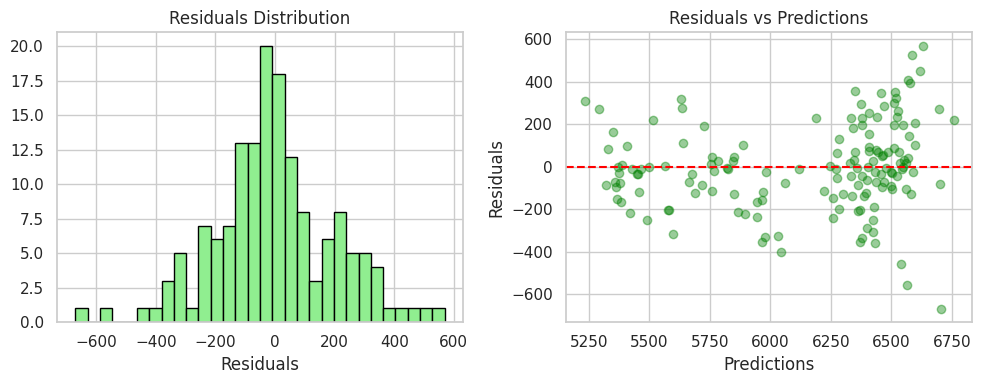

In [33]:
df_ml_2 = df_ferma.copy()

# Feature Engineering
df_ml_2['sugar_protein_ratio_cat'] = (df_ml_2['sugar_protein_ratio'] > 0.91).astype(int)
df_ml_2['energy_feed_unit_sq'] = df_ml_2['energy_feed_unit'] ** 2

# Drop old/irrelevant columns
df_ml_2 = df_ml_2.drop(['id', 'protein_percentage', 'fat_percentage',
                        'energy_feed_unit', 'sugar_protein_ratio'], axis=1)

# Define Feature Groups
cat_cols_2 = ['breed', 'pasture_type', 'sire_breed', 'age'] # 'milk_flavor' removed as it is not input
num_cols_2 = ['energy_feed_unit_sq', 'sugar_protein_ratio_cat', 'crude_protein_g']

# Preprocess
X_train_2, X_valid_2, y_train_2, y_valid_2, _, _ = preprocess_and_split(
    df_ml_2, 'milk_yield_kg', cat_cols_2, num_cols_2
)

# Train & Evaluate
model_2 = LinearRegression()
model_2.fit(X_train_2, y_train_2)
preds_2, res_2, met_2 = evaluate_regression(model_2, X_valid_2, y_valid_2, "Model 2")

- **Randomness**: The residuals are very normally distributed, and the graph is relatively symmetrical around the most frequent value. The deviation from the mean residual sum (0) is minimal.
- **Robustness**: The residual dispersion is normal. There is no clear relationship between the residuals and the predicted values. The difference between the minimum and maximum residuals for any predicted model value is minimal.


### Model №3

Adding a new feature `sire_name` and fixing non-linearity.

--- Model 3 Results ---
R²: 0.8457 | MSE: 38230.2757 | RMSE: 195.5256 | MAE: 147.0780


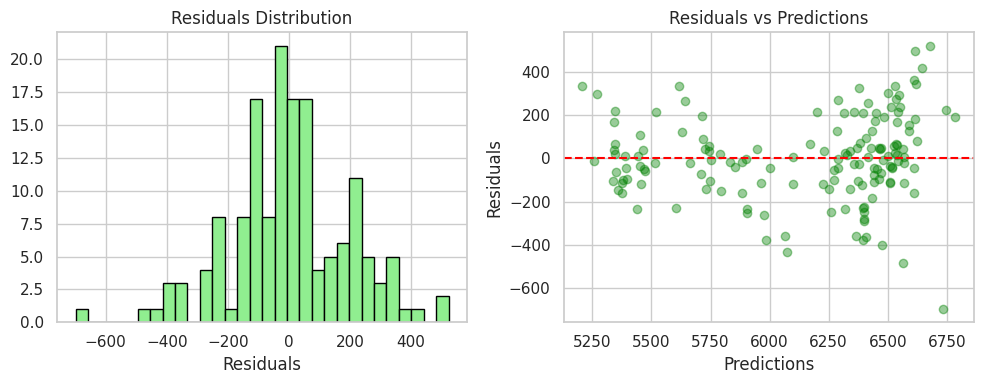

In [34]:
# Merge with dad data
df_ml_3 = df_ferma.merge(df_dad, on='id')

# Feature Engineering (Same as Model 2)
df_ml_3['sugar_protein_ratio_cat'] = (df_ml_3['sugar_protein_ratio'] > 0.91).astype(int)
df_ml_3['energy_feed_unit_sq'] = df_ml_3['energy_feed_unit'] ** 2

# Drop columns
df_ml_3 = df_ml_3.drop(['id', 'protein_percentage', 'fat_percentage',
                        'energy_feed_unit', 'sugar_protein_ratio'], axis=1)

# Define Feature Groups (Now includes 'sire_name')
cat_cols_3 = ['breed', 'pasture_type', 'sire_breed', 'age', 'sire_name']
num_cols_3 = ['energy_feed_unit_sq', 'sugar_protein_ratio_cat', 'crude_protein_g']

# Preprocess
# We capture encoder/scaler here to use them later on df_buy
X_train_3, X_valid_3, y_train_3, y_valid_3, encoder_3, scaler_3 = preprocess_and_split(
    df_ml_3, 'milk_yield_kg', cat_cols_3, num_cols_3
)

# Train & Evaluate
model_3 = LinearRegression()
model_3.fit(X_train_3, y_train_3)
preds_3, res_3, met_3 = evaluate_regression(model_3, X_valid_3, y_valid_3, "Model 3")

Let's combine the training and validation sets (for the future):

- **Randomness**: the residuals are well-ordered and normally distributed, the plot is relatively symmetrical around the most frequent value. The deviation from the mean of the residual sum is the smallest of all models.
- **Robustness**: the residual dispersion is normal.

In [35]:
# Comparison of r2_scores
metrics_df = pd.DataFrame({
    'Model 1': met_1,
    'Model 2': met_2,
    'Model 3': met_3
})
print(metrics_df)

           Model 1       Model 2       Model 3
r2        0.803413      0.831639      0.845708
mse   48710.034678  41716.194229  38230.275709
rmse    220.703499    204.245426    195.525640
mae     169.950569    153.955360    147.077980


- The third model shows the best r2_score of 0.8457, meaning that this model explains approximately 84.58% of the variance in the target feature.


In [36]:
# Let's calculate the 95% confidence interval of the best model
print('95% confidence interval =',
st.norm.interval(confidence=0.95, loc=np.mean(preds_3), scale=st.sem(preds_3)))

95% confidence interval = (np.float64(6068.076877421743), np.float64(6208.754596436998))


In [37]:
# Calculating model residuals
errors = y_valid_3 - preds_3
print(f"Residuals 95% Interval: [{np.quantile(errors, 0.025):.2f}, {np.quantile(errors, 0.975):.2f}]")

Residuals 95% Interval: [-383.34, 349.45]


This means that:

- In 95% of cases, the model underestimates by no more than 383.34 liters.
- In 95% of cases, the model overestimates by no more than 349.45 liters.

Thus, the **third model** performed best, with an average prediction error of 194.43 kg and a 95% confidence interval of (6070.586591197051, 6211.617236192927).

Yield Prediction for `df_buy`:



In [38]:
# Copying dataset
df_buy_ml = df_buy.copy()

# Imputing features
mean_vals = df_ferma[['energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio']].mean()
new_vals = mean_vals * 1.05

df_buy_ml['energy_feed_unit'] = new_vals['energy_feed_unit']
df_buy_ml['crude_protein_g'] = new_vals['crude_protein_g']
df_buy_ml['sugar_protein_ratio'] = new_vals['sugar_protein_ratio']

# Feature Engineering
df_buy_ml['energy_feed_unit_sq'] = df_buy_ml['energy_feed_unit'] ** 2
df_buy_ml['sugar_protein_ratio_cat'] = (df_buy_ml['sugar_protein_ratio'] > 0.91).astype(int)

# Transforming using Model 3's fitted Encoder/Scaler
try:
    X_buy_ohe = pd.DataFrame(
        encoder_3.transform(df_buy_ml[cat_cols_3]),
        columns=encoder_3.get_feature_names_out(cat_cols_3)
    )
    X_buy_scaled = pd.DataFrame(
        scaler_3.transform(df_buy_ml[num_cols_3]),
        columns=num_cols_3
    )
    X_buy_final = pd.concat([X_buy_ohe, X_buy_scaled], axis=1)

    # Predicting
    df_buy['_expected_milk_yield_kg'] = model_3.predict(X_buy_final)
    print(df_buy[['breed', '_expected_milk_yield_kg']].head())

except Exception as e:
    print(f"Error transforming buy data: {e}")

                  breed  _expected_milk_yield_kg
0         vis bic ideal              6581.731529
1         vis bic ideal              6317.706397
2  reflection sovereign              6284.425388
3  reflection sovereign              6593.829776
4  reflection sovereign              6535.591403


All cows are predicted to give > 6000 kg.

## <a name='classification'></a> Classification task

Training Logistic Regression Model

In [39]:
# Copying main dataset
df_log = df_ferma.copy()

Accuracy: 0.5686
Precision: 0.5378
Recall: 0.8533


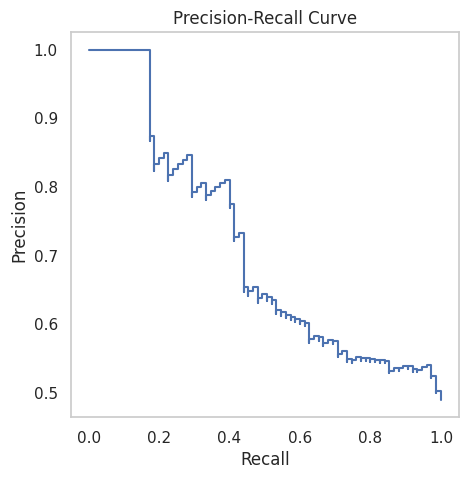

In [40]:
# Feature Engineering
df_log['milk_flavor_cat'] = (df_log['milk_flavor'] == 'tasty').astype(int)
df_log['sugar_protein_ratio_cat'] = (df_log['sugar_protein_ratio'] > 0.91).astype(int)
df_log['energy_feed_unit_sq'] = df_log['energy_feed_unit'] ** 2

# Drop unused columns
df_log = df_log.drop(['id', 'milk_yield_kg', 'milk_flavor',
                      'energy_feed_unit', 'sugar_protein_ratio'], axis=1)

# Define Features
cat_cols_clf = ['breed', 'pasture_type', 'sire_breed', 'age', 'sugar_protein_ratio_cat']
num_cols_clf = ['fat_percentage', 'protein_percentage', 'energy_feed_unit_sq', 'crude_protein_g']

# 2. Preprocess & Split using your helper function
# IMPORTANT: We capture enc_c (encoder) and scl_c (scaler) to use them later on df_buy
X_train_c, X_valid_c, y_train_c, y_valid_c, enc_c, scl_c = preprocess_and_split(
    df_log, 'milk_flavor_cat', cat_cols_clf, num_cols_clf
)

# 3. Train Model
clf = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')
clf.fit(X_train_c, y_train_c)

# 4. Basic Metrics (Threshold = 0.5)
y_pred_c = clf.predict(X_valid_c)
print(f"Accuracy: {accuracy_score(y_valid_c, y_pred_c):.4f}")
print(f"Precision: {precision_score(y_valid_c, y_pred_c):.4f}")
print(f"Recall: {recall_score(y_valid_c, y_pred_c):.4f}")

# 5. PR Curve
y_proba = clf.predict_proba(X_valid_c)[:, 1]
prec, rec, _ = precision_recall_curve(y_valid_c, y_proba)

plt.figure(figsize=(5, 5))
plt.step(rec, prec, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

**Model Performance at Default Threshold (0.5):**

- **Precision (0.5378)**: This is quite low. Ideally, we want this high to avoid buying "bad" cows.

- **Recall (0.8533)**: This is very high! The model identifies 85% of the good cows, but because Precision is low, it achieves this by casting a "wide net" and incorrectly labeling many bad cows as tasty (High False Positives).

In [41]:
# Checking thresholds
thresholds_to_test = np.linspace(0.60, 0.85, 10)
df_thresh = threshold_analysis(thresholds_to_test, y_proba, y_valid_c)
print(df_thresh)

   Threshold  Precision    Recall  False Positives
0   0.600000   0.576471  0.653333               36
1   0.627778   0.611940  0.546667               26
2   0.655556   0.647059  0.440000               18
3   0.683333   0.775000  0.413333                9
4   0.711111   0.787879  0.346667                7
5   0.738889   0.840000  0.280000                4
6   0.766667   0.833333  0.200000                3
7   0.794444   1.000000  0.160000                0
8   0.822222   1.000000  0.080000                0
9   0.850000   1.000000  0.026667                0


**Threshold Analysis:**

- At 0.60: We still have 36 False Positives. This is too risky for the farmer.

- At 0.68 - 0.71: We see a major shift. Precision jumps to ~0.77-0.78 and False Positives drop to single digits (7-9).

- At 0.80+: Precision becomes perfect (1.0), meaning 0 False Positives. However, Recall drops drastically to 0.16, meaning we would miss almost all purchasing opportunities.

- **Optimal Decision (0.69)**: We select 0.69 as the balanced threshold. It provides a strong Precision (~0.77), reducing Type I errors (False Positives) to a manageable level, while keeping Recall (0.41) high enough to actually find cows to buy.

In [42]:
# Select Optimal Threshold
OPTIMAL_THRESHOLD = 0.69
y_pred_opt = (y_proba > OPTIMAL_THRESHOLD).astype(int)

print(f"\nOptimal Threshold ({OPTIMAL_THRESHOLD}) Metrics:")
print(f"Precision: {precision_score(y_valid_c, y_pred_opt):.4f}")
print(f"Recall: {recall_score(y_valid_c, y_pred_opt):.4f}")


Optimal Threshold (0.69) Metrics:
Precision: 0.7692
Recall: 0.4000


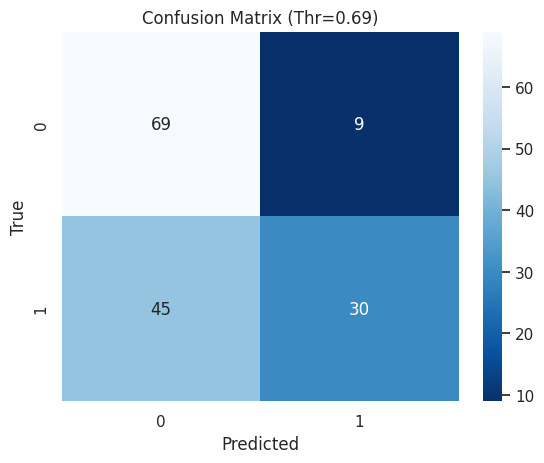

In [43]:
# Confusion Matrix for Optimal Threshold
cm = confusion_matrix(y_valid_c, y_pred_opt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title(f'Confusion Matrix (Thr={OPTIMAL_THRESHOLD})')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

The visualization confirms a conservative strategy. The model is acting like a strict gatekeeper: it rejects many good cows (high False Negatives) just to ensure that the few it lets through are very likely to be good (low False Positives).

**Milk Flavor Prediction for df_buy**

In [45]:
# Creating a clean, temporary copy of df_buy for all transformations
df_buy_clf = df_buy_ml.copy()

df_buy_clf.rename(columns={
    'current_fat_percentage': 'fat_percentage',
    'current_protein_percentage': 'protein_percentage'
}, inplace=True)

# 2. Transform Data using Classification's fitted objects (enc_c, scl_c)
X_buy_ohe = pd.DataFrame(
    enc_c.transform(df_buy_clf[cat_cols_clf]),
    columns=enc_c.get_feature_names_out(cat_cols_clf)
)
X_buy_scaled = pd.DataFrame(
    scl_c.transform(df_buy_clf[num_cols_clf]),
    columns=num_cols_clf
)
X_buy_final = pd.concat([X_buy_ohe, X_buy_scaled], axis=1)

# 3. Predict Probabilities
y_proba_buy = clf.predict_proba(X_buy_final)[:, 1]

# 4. Apply 0.69 Threshold
df_buy['expected_flavor'] = np.where(y_proba_buy > OPTIMAL_THRESHOLD, 'tasty', 'not_tasty')

# 5. Final Results
to_buy = df_buy.query('expected_flavor == "tasty"')

print(f"Total cows available: {len(df_buy)}")
print(f"Recommended cows (Threshold {OPTIMAL_THRESHOLD}): {len(to_buy)}")

if len(to_buy) > 0:
    display(to_buy[['breed', 'age', '_expected_milk_yield_kg', 'expected_flavor']])
else:
    print("No cows met the criteria.")

Total cows available: 16
Recommended cows (Threshold 0.69): 3


,breed,age,_expected_milk_yield_kg,expected_flavor
0,vis bic ideal,more_than_2_years,6581.731529,tasty
7,reflection sovereign,less_than_2_years,6369.053045,tasty
13,vis bic ideal,more_than_2_years,6359.444876,tasty


Using the alternative threshold (0.69), we found **3** cows with tasty milk.


## Final Conclusions and Recommendation

- A machine learning model was developed to help the client better manage risks when expanding the herd.

- **Yield:** All cows at EcoFarm are predicted to produce > 6000 kg/year, satisfying the quantity criteria.

- **Flavor:**
    - Using a strict threshold (0.80), no cows met the criteria (0 recommendations).
    - Using a balanced threshold (0.69), **3 cows** were identified as suitable candidates. This threshold provides a good balance, ensuring high precision (minimizing the risk of buying "bad" cows) while still allowing for herd expansion.

**Models:**
- **Linear Regression (Model 3)** performed best for yield prediction ($R^2 \approx 0.85$).
- **Logistic Regression** required threshold tuning to balance risk (Precision) vs opportunity (Recall).

**Recommendation:**
Consider purchasing the **3 identified cows** as they meet both the yield and flavor quality criteria.